## Kepler TTV WorkBook

### VS Code Virtual Environment Setup
If you are using VS Code, it is recommended to create a virtual environment for this project. Here are the steps to create a virtual environment in VS Code:

- Open the Command Palette: Press Ctrl+Shift+P (or Cmd+Shift+P on Mac).
- Search: Type Python: Create Environment and select it.
- Choose Type: Select Venv.
- Select Interpreter: Choose the base Python version you have installed (e.g., Python 3.10, 3.11).
- Wait: VS Code will create a .venv folder in your project and automatically select it as your environment.

It is recommended to install this package in "editable" mode inside a virtual environment. This allows you to modify the source code without needing to reinstall.

```bash
git clone https://github.com/jasonfrowe/bls_cuda.git
cd bls_cuda
```

Install via pip:
```bash
pip install -e .
```

### Alternative Virtual Environment Setup
If you are not using VS Code, you can still create a virtual environment using the command line:

You may find it useful to create a virtual environment for this workbook (optional)

```bash
python -m venv bls_env         # Install create virtual environment that we will name 'bls_env'
source ./bls_env/bin/activate   # Active the new environment
pip install ipykernel           # Install iPython kernel
python -m ipykernel install --user --name=bls_env  # Add Kernel to Jupyter
(now make sure you have selected `bls_env` as your active Kernel for this notebook)
```

It is recommended to install bls_cuda package in "editable" mode inside a virtual environment. This allows you to modify the source code without needing to reinstall.

```bash
git clone https://github.com/jasonfrowe/bls_cuda.git
cd bls_cuda
```

Install via pip:
```bash
pip install -e .
```
### Package requirements:
- pytfit5
- numpy
- matplotlib
- tqdm
- numba
- scipy
- astroquery
- pandas

```bash
pip install numpy matplotlib tqdm numba scipy astroquery pandas
```

It is also recommended to install ipywidgets for Jupyter notebooks
```bash
pip install ipywidgets
```

In [1]:
# import os, sys

import numpy as np

import pytfit5.bls_cpu as gbls     # BLS routines that run on the CPU
import pytfit5.transitPy5 as tpy5  # Transit processing modules 

import matplotlib.pyplot as plt  #MatPlotLib for some simple plots 

# for BLS routine
import pytfit5.transitPy5 as tpy5        # routines to handle transit photometry
import pytfit5.bls_cpu as gbls           # BLS CPU implementation 

# Transit modelling module
import pytfit5.transitmodel as transitm
import pytfit5.keplerian as kep
import pytfit5.transitfit as transitf
import pytfit5.transitplot as transitp

# Reading in CSV file 
import pandas as pd

## Read in Kepler catalogue

In [2]:
# The URL of the CSV file
url = "https://kona.ubishops.ca/architecture/KeplerARCH_20231117.csv"

# Read the CSV file into a pandas DataFrame
Kepler_cat = pd.read_csv(url)

## Get data for a specific KOI

In [3]:
KOI = 262  #The system we want 

# Get the data frame for the requested KOI
koi_df = tpy5.find_koi_rows(KOI, Kepler_cat) 

# Fetch data products and set up necessary classes.  Set raw = 1 to get raw PDC light-curves
phot, tpy5_inputs = tpy5.get_photometry(koi_df, raw = 0) 

# Get the best-fit transit model (this is different than the Arch Catalogue) 
sol = tpy5.populate_transit_model(Kepler_cat, KOI)

# Get transit-timing measurements.
ntt, tobs, omc, omc_err = tpy5.get_timing_data(Kepler_cat, KOI)

# Update flags to mark in-transit data (note: this routine does not yet account for TTVs)
kep.mark_intransit_data(phot, sol, tdurcut = 2.0)  # tdurcut is the amount of +/- time to protect centred on the transit 

Searching for KOI values starting with: 262

Found 2 confirmed planets in system 262.
Fetching model solution from: https://kona.ubishops.ca/Kepler_n/koi262.n/n0.dat
 -> Success! Found 168 timing points.
 -> Success! Found 144 timing points.


## Quick plot of photometry

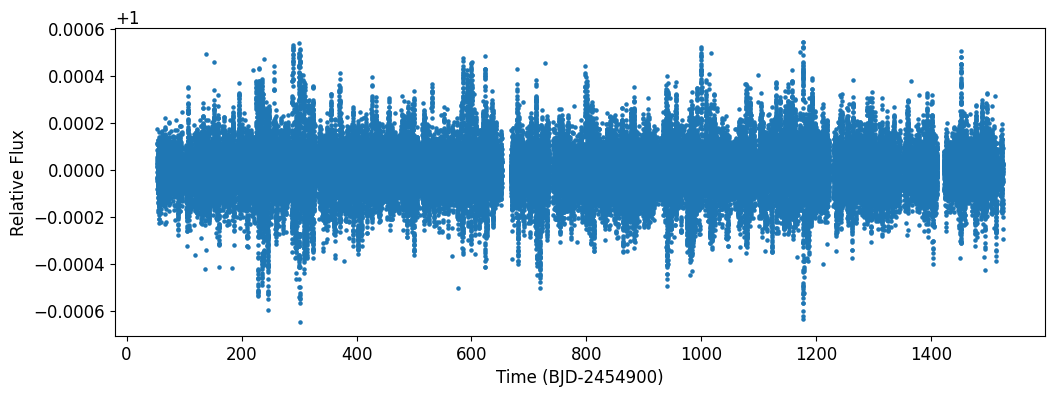

In [4]:
# Processed Light curve 
fig=plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 12})
plt.scatter(phot.time,phot.flux, s=5)
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Relative Flux')
plt.show()

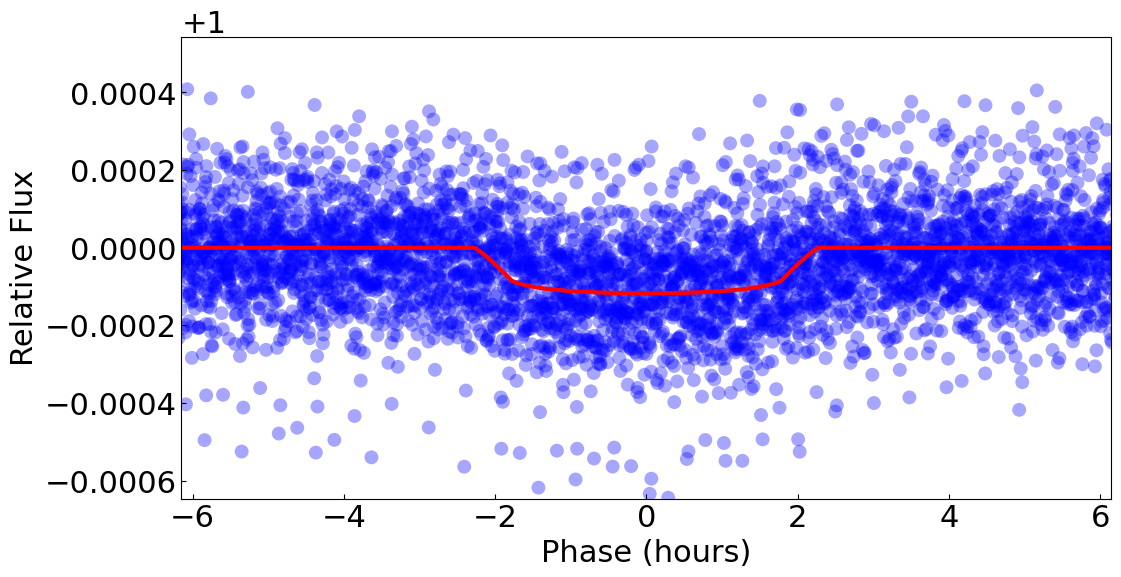

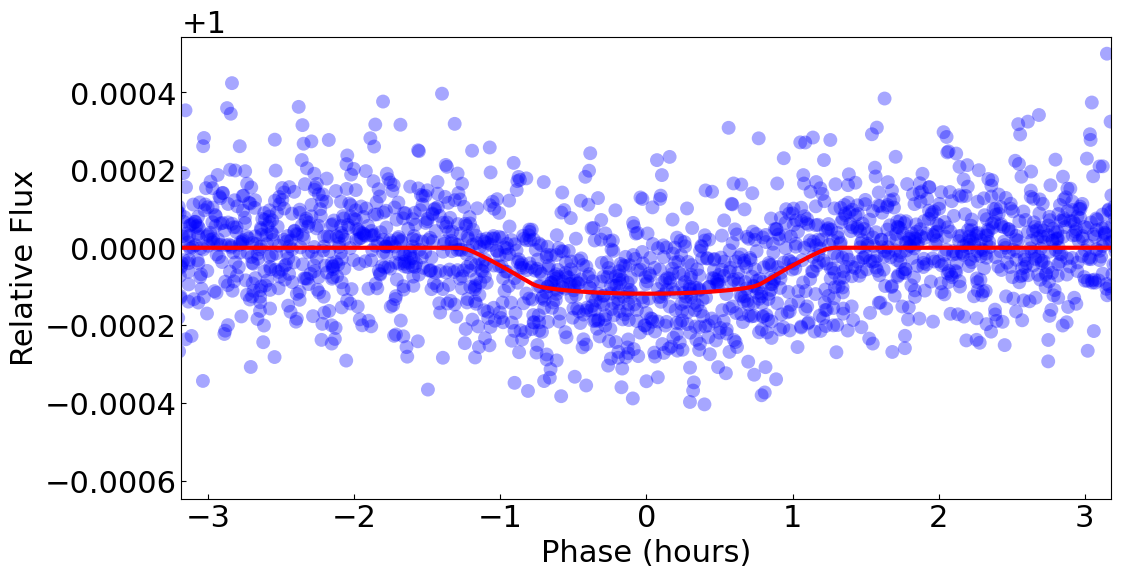

In [5]:
for pl_plot in range(sol.npl):
    transitp.plotTransit(phot, sol, pl_to_plot=pl_plot+1)

## Quick plot of TTVs

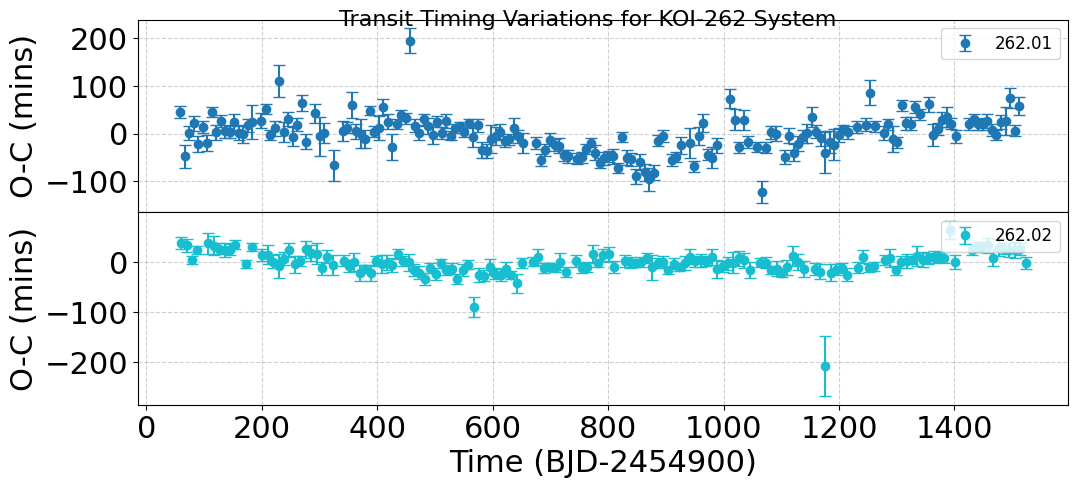

In [6]:
tpy5.plotTTVs(ntt, tobs, omc, omc_err, KOI, koi_df)

# Run data processing (only use if fetching raw data)

Data conditioning for the transit search includes:
- applying a data filter
- rejecting outliers

In [7]:
# # Run the detrending and outlier detection (if needed) 
# tpy5_inputs.boxbin = 2.0 # set detrending length
# tpy5_inputs.nfitp  = 3   # Set polynomial order
# tpy5.run_polyfilter(phot, tpy5_inputs)  # flux_f will contain the filtered photometry
# tpy5.run_cutoutliers(phot, tpy5_inputs) # data clipping, phot.icut will flag bad data

# # Processed Light curve 
# fig=plt.figure(figsize=(12, 4))
# plt.rcParams.update({'font.size': 12})
# plt.scatter(phot.time[phot.icut==0],phot.flux[phot.icut==0], s=5)
# plt.xlabel('Time (BJD-2454900)')
# plt.ylabel('Relative Flux')
# plt.show()

## Fit a new transit model

In [8]:
# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

# Fit the data - phot.flux_f is used for the fit.
# We are including the TTVs with this model. 
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot, ntt=ntt, tobs=tobs, omc=omc)

In [9]:
# See the fitted parameters (Note the error is a simple co-variance matrix at this stage)
transitp.printParams(sol_fit)

ρ* (g/cm³):                     0.9884639 ± 0.8037116
c1:                                0.3228 ± 0.0
c2:                                0.3043 ± 0.0
q1:                                   0.0 ± 0.0
q2:                                   0.0 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:        -4.741e-06 ± 3.542e-07

Planet #1:
t0 (days):                     105.6138384 ± 0.0006302
Period (days):                  7.8128615 ± 0.0000062
Impact parameter:               0.0423630 ± 6.3956947
Rp/R*:                          9.818e-03 ± 4.870e-04
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0

Planet #2:
t0 (days):                     69.9530326 ± 0.0006461
Period (days):       

## Get the current transit model 

in this example we set ntt, tobs and omc to include the TTVs in the transit model

In [10]:
# Note, we are using the re-fitted model.  Change back to 'sol' to use the original.
tmodel = transitm.transitModel(sol_fit, phot.time, itime=phot.itime, ntt=ntt, tobs=tobs, omc=omc)

## Fourier Analysis

In [11]:
from astropy.timeseries import LombScargle

In [12]:
ls = LombScargle(phot.time, phot.flux-tmodel, phot.ferr)
frequency, power = ls.autopower(maximum_frequency=48.0)

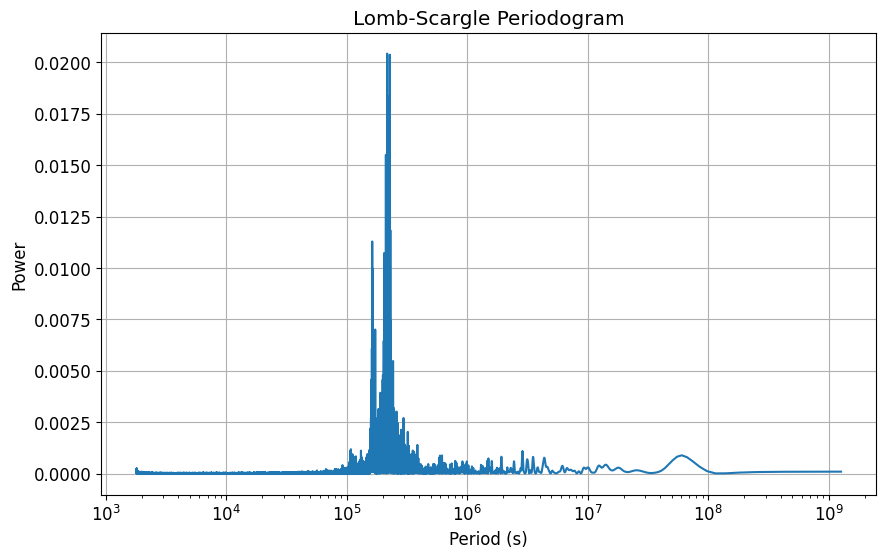

The most significant frequency is: 0.3979 c/d
Corresponding period: 2.5132 day


In [13]:
# Plotting the periodogram
plt.figure(figsize=(10, 6))
plt.plot(86400/frequency, power)
plt.title('Lomb-Scargle Periodogram')
plt.xlabel('Period (s)')
plt.ylabel('Power')
plt.xscale('log')
# plt.xlim(0.1, 1)
plt.grid(True)
plt.show()

# Find the frequency with the highest power
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency
print(f"The most significant frequency is: {best_frequency:.4f} c/d")
print(f"Corresponding period: {best_period:.4f} day")

In [14]:
def prewhiten(phot_data, tmodel, n_iterations=3, max_frequency=None):
    """
    Performs iterative pre-whitening on photometric data.

    Args:
        phot_data (object): An object with .time, .flux, and .ferr attributes.
        n_iterations (int): The number of frequencies to find and remove.
        max_frequency (astropy.units.Quantity, optional): The maximum frequency
            to search. If None, it will be determined automatically.
    """
    
    # Keep copies of the original data for plotting later
    original_time = np.copy(phot_data.time)
    original_flux = np.copy(phot_data.flux) - tmodel
    
    # This will be our working flux array, which gets modified in each step
    residual_flux = np.copy(phot_data.flux) - tmodel
    
    found_frequencies = []
    full_model = np.zeros_like(original_flux)

    # Setup plots to visualize the process
    fig, axes = plt.subplots(n_iterations, 1, figsize=(12, 4 * n_iterations),
                             sharex=True)
    if n_iterations == 1: # Matplotlib returns a single axes object if n=1
        axes = [axes]
    fig.suptitle('Iterative Pre-whitening Process', fontsize=16)

    for i in range(n_iterations):
        print(f"--- Iteration {i+1} ---")
        
        # 1. Calculate the periodogram on the current (residual) flux
        ls = LombScargle(phot_data.time, residual_flux, phot_data.ferr)
        frequency, power = ls.autopower(maximum_frequency=max_frequency)
        
        # 2. Find the most significant frequency
        best_frequency = frequency[np.argmax(power)]
        best_period = (1 / best_frequency)
        print(f"Found peak frequency: {best_frequency:.4f} (Period: {best_period:.4f})")
        
        # 3. Fit the model for the best frequency
        # The .model() method gives the best-fit sinusoid for that frequency
        single_freq_model = ls.model(phot_data.time, best_frequency)
        
        # Store results. Amplitude can be estimated from the model's range.
        amplitude = (single_freq_model.max() - single_freq_model.min()) / 2
        found_frequencies.append({
            'frequency': best_frequency,
            'period': best_period,
            'amplitude': amplitude
        })
        print(f"Fitted amplitude: {amplitude:.4f}\n")

        # Add this single-frequency model to our cumulative full model
        full_model += single_freq_model
        
        # 4. Subtract the model to create the new residuals for the next iteration
        residual_flux -= single_freq_model
        
        # --- Plotting for this iteration ---
        ax = axes[i]
        ax.plot(frequency, power)
        ax.set_title(f'Iteration {i+1}: Periodogram of Residuals')
        ax.set_ylabel('Power')
        ax.set_xscale('log')
        ax.axvline(best_frequency, color='r', linestyle='--', alpha=0.8,
                   label=f'Found Freq: {best_frequency:.2f}')
        ax.legend()

    axes[-1].set_xlabel(f'Frequency (c/d)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()
    
    # --- Final Summary ---
    print("\n--- Summary of Found Frequencies ---")
    for i, params in enumerate(found_frequencies):
        print(f"Signal {i+1}: Period={params['period']:.4f}, "
              f"Frequency={params['frequency']:.4f}, "
              f"Amplitude={params['amplitude']:.3f}")

    # --- Final Plot: Original Data vs. Full Model ---
    plt.figure(figsize=(12, 6))
    plt.errorbar(original_time, original_flux, yerr=phot_data.ferr, fmt='.',
                 alpha=0.3, label='Original Data',zorder=1)
    plt.plot(original_time, full_model, color='k',
             label='Full Multi-Frequency Model',zorder=2)
    plt.title('Original Data vs. Reconstructed Model')
    plt.xlabel('Time (days)')
    plt.ylabel('Flux')
    plt.legend()
    plt.grid(True)
    plt.show()

    return full_model

--- Iteration 1 ---
Found peak frequency: 0.3979 (Period: 2.5132)
Fitted amplitude: 0.0000

--- Iteration 2 ---
Found peak frequency: 0.3782 (Period: 2.6442)
Fitted amplitude: 0.0000

--- Iteration 3 ---
Found peak frequency: 0.3965 (Period: 2.5218)
Fitted amplitude: 0.0000

--- Iteration 4 ---
Found peak frequency: 0.3831 (Period: 2.6104)
Fitted amplitude: 0.0000

--- Iteration 5 ---
Found peak frequency: 0.3854 (Period: 2.5948)
Fitted amplitude: 0.0000

--- Iteration 6 ---
Found peak frequency: 0.3927 (Period: 2.5463)
Fitted amplitude: 0.0000

--- Iteration 7 ---
Found peak frequency: 0.3911 (Period: 2.5569)
Fitted amplitude: 0.0000

--- Iteration 8 ---
Found peak frequency: 0.4084 (Period: 2.4487)
Fitted amplitude: 0.0000

--- Iteration 9 ---
Found peak frequency: 0.3891 (Period: 2.5703)
Fitted amplitude: 0.0000

--- Iteration 10 ---
Found peak frequency: 0.3990 (Period: 2.5063)
Fitted amplitude: 0.0000

--- Iteration 11 ---
Found peak frequency: 0.5302 (Period: 1.8859)
Fitted ampli

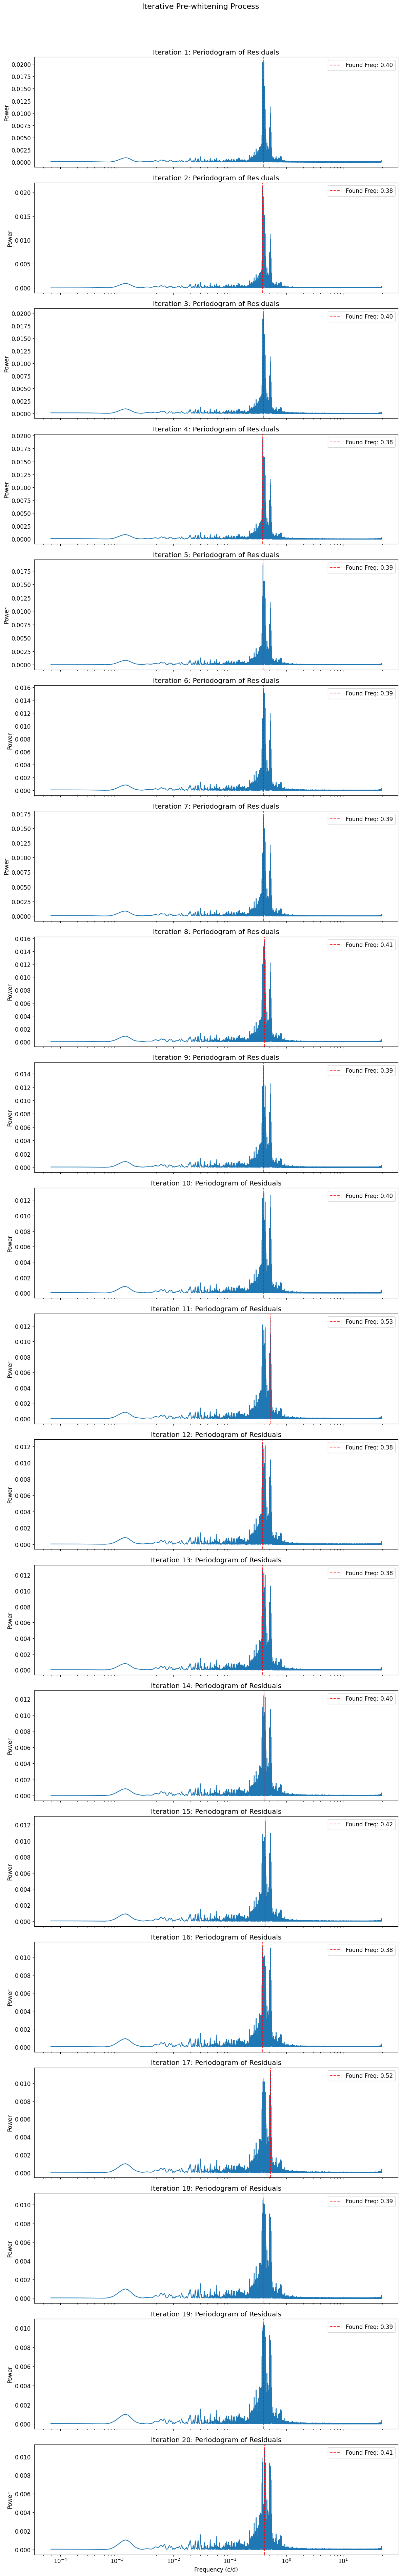


--- Summary of Found Frequencies ---
Signal 1: Period=2.5132, Frequency=0.3979, Amplitude=0.000
Signal 2: Period=2.6442, Frequency=0.3782, Amplitude=0.000
Signal 3: Period=2.5218, Frequency=0.3965, Amplitude=0.000
Signal 4: Period=2.6104, Frequency=0.3831, Amplitude=0.000
Signal 5: Period=2.5948, Frequency=0.3854, Amplitude=0.000
Signal 6: Period=2.5463, Frequency=0.3927, Amplitude=0.000
Signal 7: Period=2.5569, Frequency=0.3911, Amplitude=0.000
Signal 8: Period=2.4487, Frequency=0.4084, Amplitude=0.000
Signal 9: Period=2.5703, Frequency=0.3891, Amplitude=0.000
Signal 10: Period=2.5063, Frequency=0.3990, Amplitude=0.000
Signal 11: Period=1.8859, Frequency=0.5302, Amplitude=0.000
Signal 12: Period=2.6663, Frequency=0.3751, Amplitude=0.000
Signal 13: Period=2.6500, Frequency=0.3774, Amplitude=0.000
Signal 14: Period=2.4970, Frequency=0.4005, Amplitude=0.000
Signal 15: Period=2.3752, Frequency=0.4210, Amplitude=0.000
Signal 16: Period=2.6207, Frequency=0.3816, Amplitude=0.000
Signal 17: 

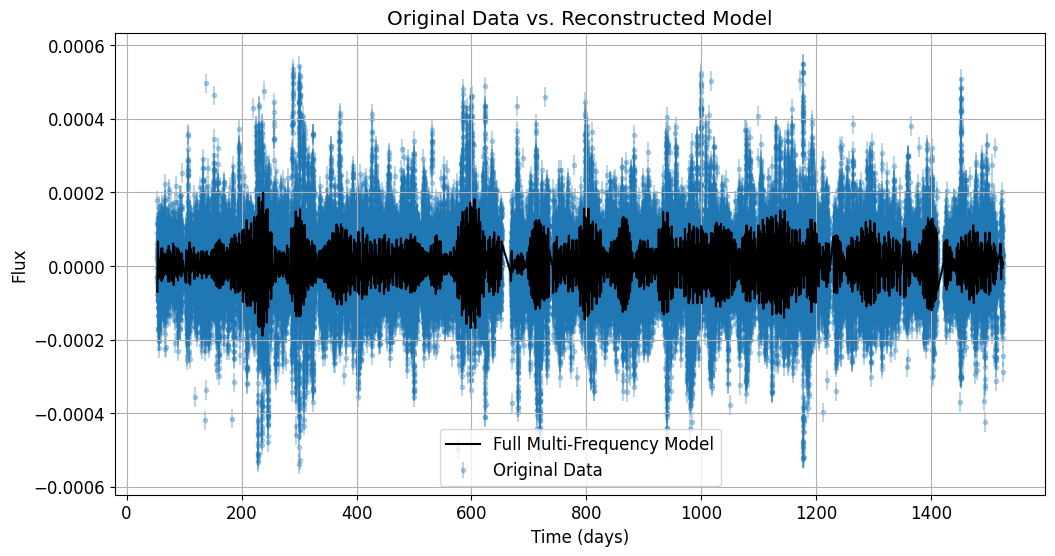

In [15]:
full_model = prewhiten(phot, tmodel, n_iterations=20, max_frequency=48)

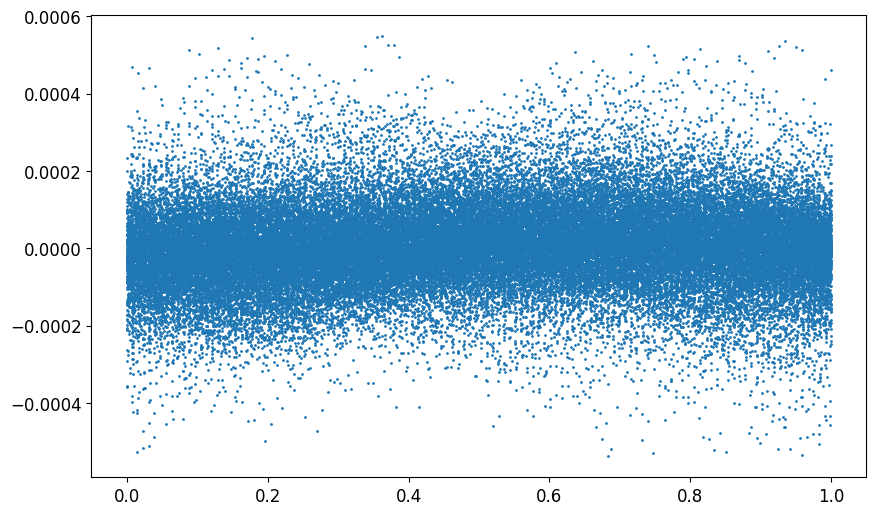

In [16]:
phase = phot.time/best_period - np.floor(phot.time/best_period)
plt.figure(figsize=(10, 6))
plt.scatter(phase, phot.flux-tmodel,s=1)
plt.show()

# Run BLS Search  
 - takes about 1-2 minutes to run depending on your computer (code will use all your CPU cores)
 - default is to search from 0.5 days to half the length of the data (~700 days).
 - Change freq2 to make BLS run faster if you don't care about very short periods)

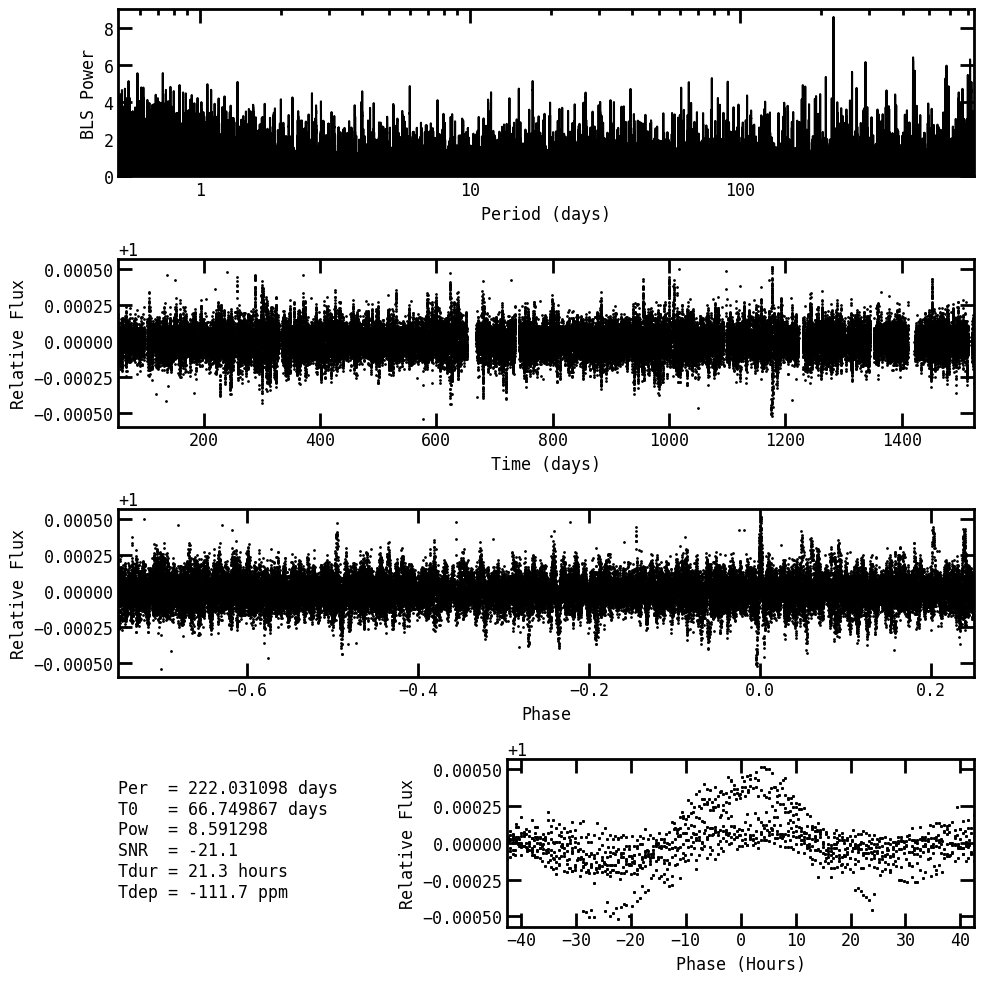

In [17]:
# Set up the BLS inputs and run
gbls_inputs          = gbls.gbls_inputs_class() # Initialize needed inputs
gbls_inputs.zerotime = 0.0
gbls_inputs.Rstar    = tpy5_inputs.mstar
gbls_inputs.Mstar    = tpy5_inputs.rstar
gbls_inputs.plots    = 1 # 1=X11, 2=both, 0=none
gbls_inputs.freq1    = 2/(np.max(phot.time) - np.min(phot.time))
gbls_inputs.freq2    = -1 # default value of 0.5 day period
gbls_inputs.filename = tpy5_inputs.photfile  # Used for naming the file, extension replaced with PNG.

# Run BLS, applying data cuts and removing the current best-fit model (so we are searching the residuals)
gbls_ans = gbls.bls(gbls_inputs, phot.time[(phot.icut == 0)], phot.flux_f[(phot.icut == 0)] - tmodel[(phot.icut == 0)] - full_model[(phot.icut == 0)])

## Measure TTVs  

We can remeasure the TTVs

In [18]:
pflag  = 0 # 1 = use the previous O-C measurements to initialize the next fit 
pstart = 0 # set the guess for the first O-C measurement 
# pflag  = [1, 1, 0] 
# pstart = [omc[0,0], omc[1,0], 0] # Example that uses the exisiting O-C measurements to initialize the model
phot.flux_f -= full_model
ntt_new, tobs_new, omc_new, omc_err_new = tpy5.fit_ttvs(phot, sol_fit, ntt, tobs, omc, pflag = pflag, pstart = pstart)

100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


## Plot that compares the new and old TTVs

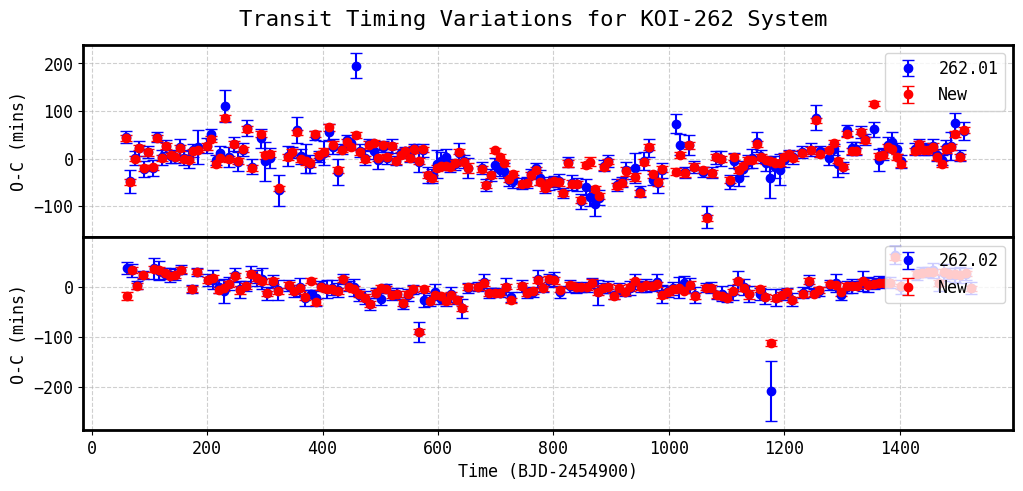

In [19]:
num_planets = len(ntt)

# Create a figure and a set of subplots.
# sharex=True is the key to linking the x-axes.
# We make the figure taller based on the number of planets.
fig, axes = plt.subplots(
    nrows=num_planets,
    ncols=1,
    figsize=(12, 2.5 * num_planets),
    sharex=True
)
plt.rcParams.update({'font.size': 12})

# If there's only one planet, axes is not a list, so we make it one
if num_planets == 1:
    axes = [axes]

colors = plt.get_cmap('tab10')(np.linspace(0, 1, num_planets))

# Loop through each planet and plot on its dedicated axis
for i, ntt_1 in enumerate(ntt):
    # Select the correct axis for this planet
    ax = axes[i]
    
    # Get the data slice for the current planet
    time_data = tobs[i, 0:ntt_1]
    omc_data = omc[i, 0:ntt_1] * 24 * 60  # Convert to minutes
    omc_error_data = omc_err[i, 0:ntt_1] * 24 * 60 # Convert to minutes

    ax.errorbar(
        time_data[omc_error_data > 0],
        omc_data[omc_error_data > 0],
        yerr=omc_error_data[omc_error_data > 0],
        fmt='o',
        linestyle='none',
        capsize=4.0,
        label=str(koi_df["KOI"].values[i]),
        color="blue" #colors[i]
    )

    # Get the data slice for the current planet
    time_data = tobs_new[i, 0:ntt_new[i]]
    omc_data = omc_new[i, 0:ntt_new[i]] * 24 * 60  # Convert to minutes
    omc_error_data = omc_err_new[i, 0:ntt_new[i]] * 24 * 60 # Convert to minutes

    ax.errorbar(
        time_data[omc_error_data > 0],
        omc_data[omc_error_data > 0],
        yerr=omc_error_data[omc_error_data > 0],
        fmt='o',
        linestyle='none',
        capsize=4.0,
        label="New",
        color="red"
    )
    
    # Set the y-label for each subplot
    ax.set_ylabel('O-C (mins)')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.6)

# The x-axis label only needs to be set for the bottom-most plot
axes[-1].set_xlabel('Time (BJD-2454900)')

# Add a title for the entire figure
fig.suptitle(f'Transit Timing Variations for KOI-{str(KOI)} System', fontsize=16, y=0.95)

fig.subplots_adjust(hspace=0)

plt.show()

## Things to add:

- visualize an individual transit fit for timing measurements
- flag overlapping transits
- function to export OMC values to .tt format
- Fourier decomposition of the light-curve 